# Statistiques sur les données de Versailles

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.ops import transform

def round_coordinates(geom, precision=6):
    return transform(lambda x, y: (round(x, precision), round(y, precision)), geom)

trajectory = gpd.read_file("../../my-home-is-my-secret/my-home-is-my-secret-master/input/trajectory_versailles.shp")

print(trajectory.head())

# Vérifier le nombre de lignes
print(f"Nombre d'entités : {len(trajectory)}")

truncated = gpd.read_file("../../my-home-is-my-secret/my-home-is-my-secret-master/output/truncated.shp")

print(truncated.head())

# Vérifier le nombre de lignes
print(f"Nombre d'entités : {len(truncated)}")

# Arrondir les géométries
truncated['geometry'] = truncated['geometry'].apply(round_coordinates)
trajectory['geometry'] = trajectory['geometry'].apply(round_coordinates)

   participan                                           geometry
0      999993  LINESTRING (2.04346 48.78642, 2.04401 48.78648...
1     9999915  LINESTRING (2.13064 48.80136, 2.13056 48.80138...
2     9999916  LINESTRING (2.13187 48.79912, 2.13185 48.79908...
3     9999924  LINESTRING (2.15365 48.79264, 2.15374 48.79263...
4     9999932  LINESTRING (2.14872 48.80995, 2.14876 48.80975...
Nombre d'entités : 13
                                            geometry
0  LINESTRING (2.14852 48.81304, 2.14832 48.8132,...
1  LINESTRING (2.13374 48.7953, 2.13576 48.79588,...
2  LINESTRING (2.12281 48.73039, 2.12231 48.73048...
3  LINESTRING (2.14334 48.79678, 2.14334 48.79687...
4  LINESTRING (2.14057 48.80552, 2.14061 48.80553...
Nombre d'entités : 12


In [ ]:
# Trouver la correspondance pour chaque trajectoire tronquée
matches = []
for truncated_index, truncated_row in truncated.iterrows():
    print("test1")
    truncated_geom = truncated_row['geometry']
    best_match_id = None
    
    # Comparer avec toutes les trajectoires originales
    for _, original_row in trajectory.iterrows():
        print("test2")
        original_geom = original_row['geometry']
        
        # Vérifier si la trajectoire tronquée est contenue dans l'originale
        if original_geom.contains(truncated_geom):
            print("test3")
            best_match_id = original_row['participan']
            break  # Sortir de la boucle dès qu'une correspondance est trouvée
    
    # Ajouter la correspondance à la liste
    matches.append((truncated_index, best_match_id))

# Créer un DataFrame pour les correspondances
matches_df = pd.DataFrame(matches, columns=['truncated_index', 'original_id'])

# Afficher les correspondances
print(matches_df.head())

test1
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test1
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test1
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test2
test1
test2
test2
test2
test2
test2
test2


In [ ]:
match_trajectory = []

for match_index, match_row in matches_df.iterrows():
    truncated_index = match_row['truncated_index']
    original_index = match_row['original_id']
    
    # Gérer les valeurs NaN dans original_index
    if pd.isna(original_index):  # Si original_index est NaN
        print(f"Avertissement : original_id est NaN pour la ligne {match_index}")
        continue  # Passer à l'itération suivante
    
    # Convertir original_index en entier
    original_index = int(original_index)
    
    # Vérifier si original_index existe dans trajectory
    matching_rows = trajectory.loc[trajectory['id'] == original_index, 'geometry']
    
    if not matching_rows.empty:  # S'il y a une correspondance
        path = matching_rows.values[0]  # Récupérer la première géométrie correspondante
    else:
        print(f"Avertissement : Aucune correspondance trouvée pour original_id = {original_index}")
        continue  # Passer à l'itération suivante
    
    # Convertir truncated_index en entier et récupérer la trajectoire tronquée
    try:
        path_truncated = truncated.iloc[int(truncated_index)].values[0]
    except (IndexError, ValueError) as e:
        print(f"Avertissement : Erreur avec truncated_index {truncated_index} : {e}")
        continue  # Passer à l'itération suivante
    
    # Ajouter à la liste
    match_trajectory.append((original_index, truncated_index, path, path_truncated))

# Créer un DataFrame avec les résultats
trajectory_and_truncated = pd.DataFrame(match_trajectory, columns=['original_id', 'truncated_index', 'original_trajectory', 'truncated_trajectory'])

# Afficher le DataFrame résultant
print(trajectory_and_truncated.head())

NameError: name 'matches_df' is not defined

In [ ]:
trajectory_and_truncated.to_csv('versailles_test.csv', index=False, encoding='utf-8')

In [ ]:
#Calcul des trajectoires supprimées
removed_trajectory = len(trajectory) - len(truncated)
print(f"Nombre de trajectoires supprimées : {removed_trajectory}")

Nombre de trajectoires supprimées : 114


In [ ]:
from shapely import wkt
from shapely.geometry import LineString

# Fonction pour compter les points dans une géométrie Shapely
def count_points(geom):
    if geom is None or pd.isna(geom):  # Gérer les valeurs None ou NaN
        return 0
    if isinstance(geom, LineString):  # Vérifier si c'est un LineString
        return len(geom.coords)  # Retourner le nombre de points
    return 0  # Retourner 0 pour les autres types de géométries

trajectory_and_truncated['trajectory_count'] = trajectory_and_truncated['original_trajectory'].apply(count_points)
trajectory_and_truncated['truncated_count'] = trajectory_and_truncated['truncated_trajectory'].apply(count_points)

# Filtrer pour exclure les lignes où 'truncated_trajectory' est None
valid_trajectories = trajectory_and_truncated.dropna(subset=['original_trajectory'])


# Calculer le nombre total de points enlevés
valid_trajectories['points_removed'] = valid_trajectories['trajectory_count'] - valid_trajectories['truncated_count']
total_points_removed = valid_trajectories['points_removed'].sum()

print(f"Nombre total de points enlevés : {total_points_removed}")

# Nombre moyen de points enlevés par trajectoire
average_points_removed = valid_trajectories['points_removed'].mean()
print(f"Nombre moyen de points enlevés par trajectoire : {average_points_removed:.2f}")

#Nombre moyen de points par trajectoire
print(f"Nombre moyen de points par trajectoire : {trajectory_and_truncated['trajectory_count'].mean():.2f}")
print(f"Nombre moyen de points par trajectoire tronquée: {trajectory_and_truncated['truncated_count'].mean():.2f}")

Nombre total de points enlevés : 1007
Nombre moyen de points enlevés par trajectoire : 50.35
Nombre moyen de points par trajectoire : 100.00
Nombre moyen de points par trajectoire tronquée: 49.65


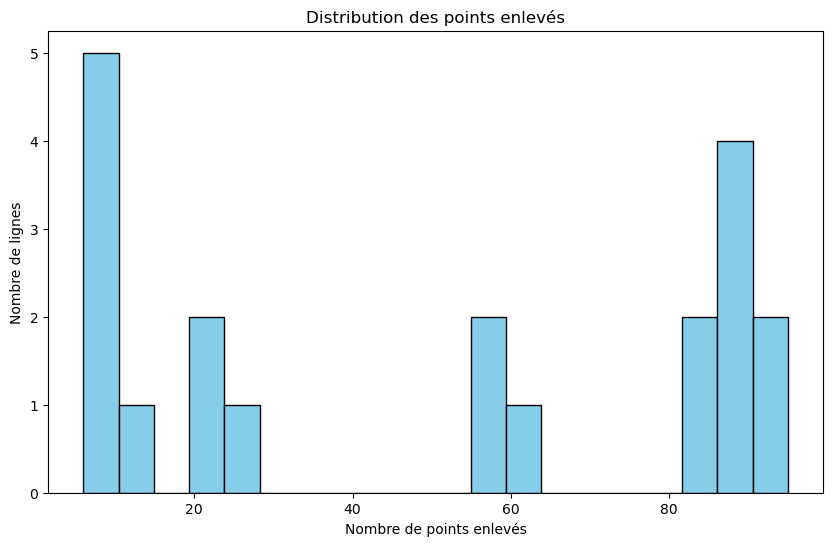

In [ ]:
import matplotlib.pyplot as plt

# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = valid_trajectories['points_removed'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(valid_trajectories['points_removed'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points enlevés')
plt.show()

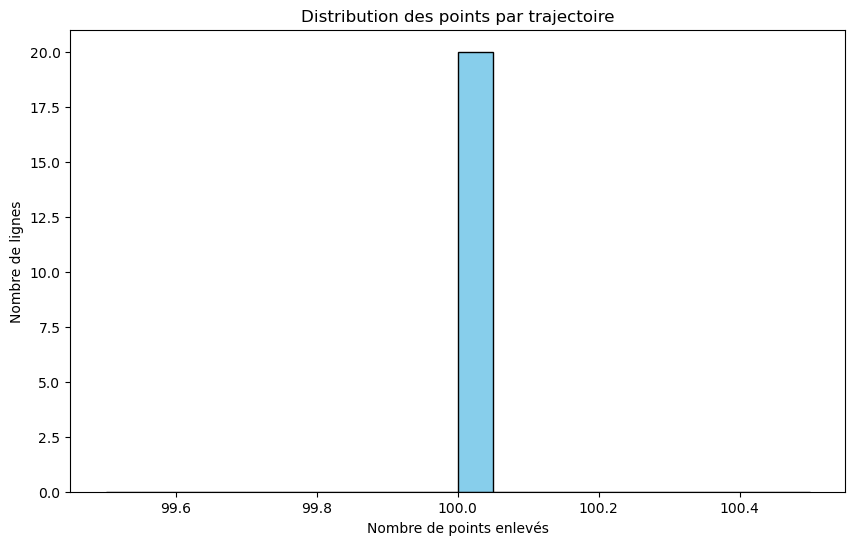

In [ ]:
# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = trajectory_and_truncated['trajectory_count'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(trajectory_and_truncated['trajectory_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points par trajectoire')
plt.show()

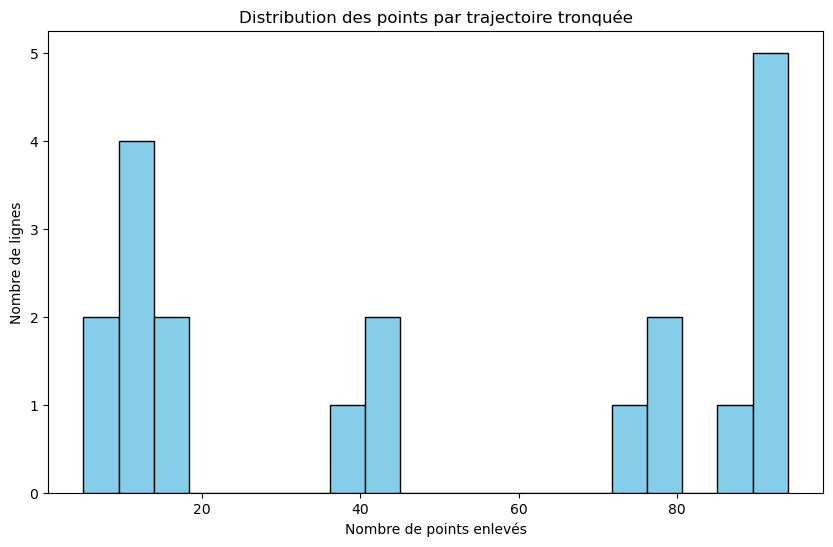

In [ ]:
# Grouper les données par 'points_removed' et compter le nombre de lignes
points_removed_counts = trajectory_and_truncated['truncated_count'].value_counts().sort_index()

# Histogramme des points enlevés
plt.figure(figsize=(10, 6))
plt.hist(trajectory_and_truncated['truncated_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de points enlevés')
plt.ylabel('Nombre de lignes')
plt.title('Distribution des points par trajectoire tronquée')
plt.show()

le taux de réduction moyenne : 50.35


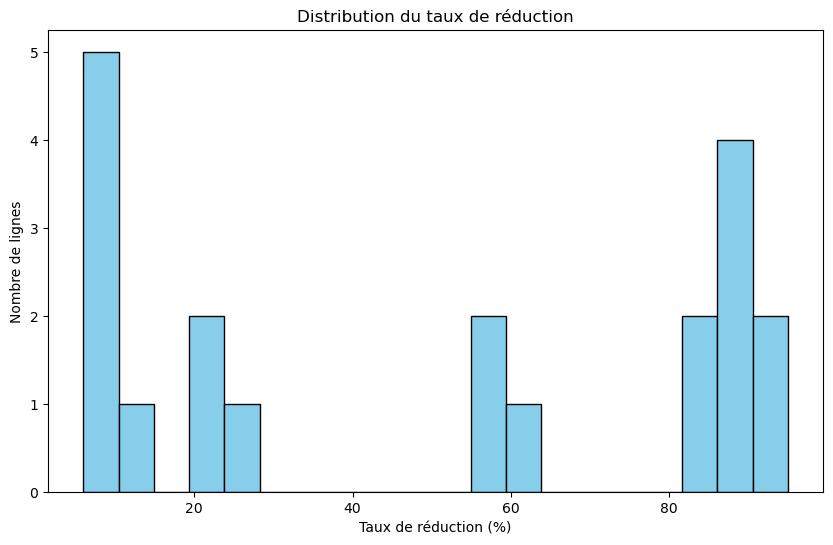

In [ ]:
# Calculer le taux de réduction
valid_trajectories['reduction_rate'] = valid_trajectories['points_removed'] / valid_trajectories['trajectory_count'] * 100

# Statistiques descriptives pour le taux de réduction
print(f"le taux de réduction moyenne : {valid_trajectories['reduction_rate'].mean():.2f}")

# Histogramme du taux de réduction
plt.figure(figsize=(10, 6))
plt.hist(valid_trajectories['reduction_rate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Taux de réduction (%)')
plt.ylabel('Nombre de lignes')
plt.title('Distribution du taux de réduction')
plt.show()